In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from src.utilities import build_mesh
from src.covariance_function import Gaussian as GaussianCovariance
from src.covariance_function import JCSS, Matern
from src.random_field import MatrixDecomposition as MD
from src.probability_distribution import Gaussian, LogNormal

### Papers

[Advances in Gaussian random field generation: a review](https://link.springer.com/content/pdf/10.1007/s10596-019-09867-y.pdf)

### Build mesh - material points

In [2]:
x = build_mesh(5e-3, 50, 50)

Number of nodes: 2500


### Material properties

In [3]:
lc = 25
mean_fc = 42.3
std_dev = 5

### Build correlation matrix

In [4]:
# jcss = JCSS(lc, 0.0)
# C = jcss.build_correlation_matrix(x)
# jcss.visualise(C)

In [5]:
# gc = GaussianCovariance(lc)
# C = gc.build_correlation_matrix(x)
# gc.visualise(C)

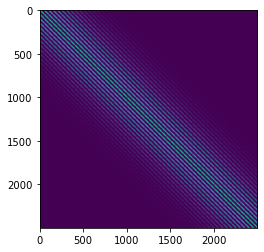

In [6]:
matern = Matern(lc, nu=5/2)
C = matern.build_correlation_matrix(x)
matern.visualise(C)

### Build Gaussian distribution

/Users/mark/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/mark/opt/anaconda3/lib/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/mark/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4193: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


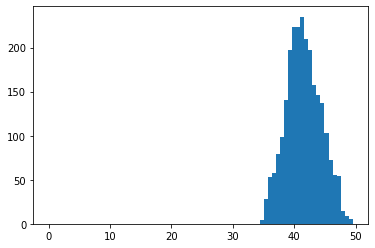

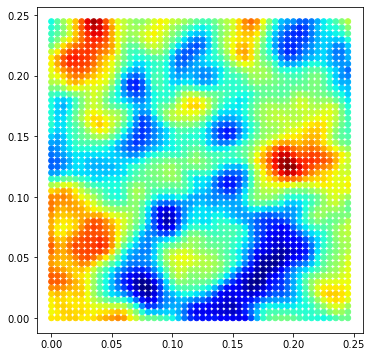

In [7]:
gaussian = Gaussian(mean_fc, std_dev)
md = MD(C, gaussian)
K = md.build_distribution()
plt.hist(K, 75, range=(0, np.max(K)));
md.visualise(x, K);

In [8]:
gaussian.print_distribution_properties(K)

Mean : 41.52
Standard deviation : 2.82


### Build log-normal distribution

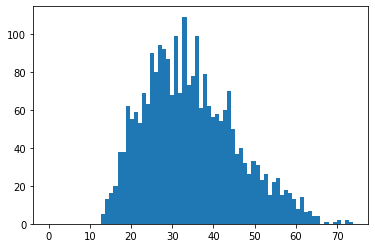

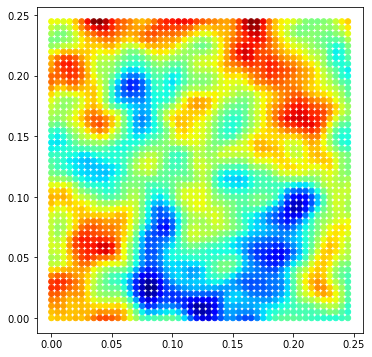

In [9]:
lognormal = LogNormal(mean_fc, 800)
md = MD(C, lognormal)
K = md.build_distribution()
plt.hist(K, 75, range=(0, np.max(K)));
md.visualise(x, np.log(K))

In [10]:
lognormal.print_distribution_properties(K)

Mean : 34.53
Standard deviation : 11.15
